In [1]:
#import zipfile

#zip_path = "Resources.zip" 
#extract_to = "Dataset"

#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_to)

In [24]:
import os
data_path_train = "Dataset/training"
data_path_test = "Dataset/testing"

In [25]:
#!~/new_python_3_11_env/bin/python3 -m pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu121
#!~/new_python_3_11_env/bin/python3 -m pip install medpy

In [26]:
import glob
import nibabel as nib
import numpy as np
import monai

def get_ed_es_frames(config_path):
    """Extract ED and ES frame numbers from the info.cfg file."""

    ed_frame, es_frame = None, None
    with open(config_path, 'r') as f:
        for line in f:
            if line.startswith('ED:'):
                ed_frame = int(line.split(':')[1].strip())
            elif line.startswith('ES:'):
                es_frame = int(line.split(':')[1].strip())
    return ed_frame, es_frame


In [27]:
def build_dict_acdc(data_path, mode='train'):
    """
    This function returns a list of dictionaries, each containing the paths to the 2D slices 
    of the 3D MRI images and their corresponding masks.
    """
    if mode not in ["train", "val", "test"]:
        raise ValueError(f"Please choose a mode in ['train', 'val', 'test']. Current mode is {mode}.")
    
    dicts = []
    
    # Loop over all patient directories
    patient_dirs = [d for d in glob.glob(os.path.join(data_path, '*')) if os.path.isdir(d)]
    
    for patient_dir in patient_dirs:
        patient_id = os.path.basename(patient_dir)
        config_path = os.path.join(patient_dir, "Info.cfg")
        
        if not os.path.exists(config_path):
            continue
        
        ed_frame, es_frame = get_ed_es_frames(config_path)
        
        # Identify the ED and ES image and mask paths
        ed_img_path = os.path.join(patient_dir, f"{patient_id}_frame{ed_frame:02d}.nii.gz")
        ed_mask_path = os.path.join(patient_dir, f"{patient_id}_frame{ed_frame:02d}_gt.nii.gz")
        es_img_path = os.path.join(patient_dir, f"{patient_id}_frame{es_frame:02d}.nii.gz")
        es_mask_path = os.path.join(patient_dir, f"{patient_id}_frame{es_frame:02d}_gt.nii.gz")
        
        for img_path, mask_path in [(ed_img_path, ed_mask_path), (es_img_path, es_mask_path)]:
            if not os.path.exists(img_path) or not os.path.exists(mask_path):
                continue
            
            # Load the 3D image and mask using nibabel
            img_volume = nib.load(img_path).get_fdata()
            mask_volume = nib.load(mask_path).get_fdata()
            
            # Ensure we have the same number of slices for image and mask
            num_slices = img_volume.shape[2]
            
            # Extract 2D slices
            for slice_idx in range(num_slices):
                img_slice = img_volume[:, :, slice_idx]
                mask_slice = mask_volume[:, :, slice_idx]
                
                dicts.append({'img': img_slice, 'mask': mask_slice})
    
    return dicts


In [28]:
class LoadHeartData(monai.transforms.Transform):
    """
    This custom Monai transform loads 2D slices of MRI data and their corresponding mask for heart segmentation.
    """
    def __init__(self, keys=None):
        pass
    
    def __call__(self, sample):
        img_slice = sample['img']
        mask_slice = sample['mask'] 
        
        # Ensure the image and mask are in compatible formats
        img_slice = np.array(img_slice, dtype=np.float32)
        mask_slice = np.array(mask_slice, dtype=np.uint8) 
        
        # Return the slice and mask with metadata. NOT SURE ABOUT THE METATDATA
        return {'img': img_slice, 'mask': mask_slice, 'img_meta_dict': {'affine': np.eye(2)}, 
                'mask_meta_dict': {'affine': np.eye(2)}}

In [29]:
#from sklearn.model_selection import train_test_split

# Construct the list of dictionaries
#train_dict_list = build_dict_acdc(data_path_train, mode='train')
#test_dict_list = build_dict_acdc(data_path_test, mode='test')
#print(train_dict_list[0].keys())
#print(test_dict_list[0].keys())

# Split the data
#train_data, val_data = train_test_split(train_dict_list, test_size=0.2, random_state=42) # every time you run the script, the data is split the same way.

# Construct CacheDataset from the list of dictionaries and apply the transform
#train_dataset = monai.data.CacheDataset(data=train_data, transform=LoadHeartData())
#val_dataset = monai.data.CacheDataset(data=val_data, transform=LoadHeartData())

In [30]:
import wandb
# Start a new wandb run to track this script.
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="DLMI_Project",
    # Set the wandb project where this run will be logged.
    project="DLMI_Project",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 1e-4,
        "architecture": "Basic U-Net",
        "dataset": "ACDC",
        "epochs": 50,
    },
)

In [31]:
HEADER = ["Name", "Dice LV", "Volume LV", "Err LV(ml)",
          "Dice RV", "Volume RV", "Err RV(ml)",
          "Dice MYO", "Volume MYO", "Err MYO(ml)"]

#
# Functions to process files, directories and metrics aka loss function
#
def metrics(img_gt, img_pred, voxel_size):
    """
    Function to compute the metrics between two segmentation maps given as input.

    Parameters
    ----------
    img_gt: np.array
    Array of the ground truth segmentation map.

    img_pred: np.array
    Array of the predicted segmentation map.

    voxel_size: list, tuple or np.array
    The size of a voxel of the images used to compute the volumes.

    Return
    ------
    A list of metrics in this order, [Dice LV, Volume LV, Err LV(ml),
    Dice RV, Volume RV, Err RV(ml), Dice MYO, Volume MYO, Err MYO(ml)]
    """

    if img_gt.ndim != img_pred.ndim:
        raise ValueError("The arrays 'img_gt' and 'img_pred' should have the "
                         "same dimension, {} against {}".format(img_gt.ndim,
                                                                img_pred.ndim))

    res = []
    # Loop on each classes of the input images
    for c in [3, 1, 2]:
        # Copy the gt image to not alterate the input
        gt_c_i = np.copy(img_gt)
        gt_c_i[gt_c_i != c] = 0

        # Copy the pred image to not alterate the input
        pred_c_i = np.copy(img_pred)
        pred_c_i[pred_c_i != c] = 0

        # Clip the value to compute the volumes
        gt_c_i = np.clip(gt_c_i, 0, 1)
        pred_c_i = np.clip(pred_c_i, 0, 1)

        # Compute the Dice
        dice = dc(gt_c_i, pred_c_i)

        # Compute volume
        volpred = pred_c_i.sum() * np.prod(voxel_size) / 1000.
        volgt = gt_c_i.sum() * np.prod(voxel_size) / 1000.

        res += [dice, volpred, volpred-volgt]

    return res

In [32]:
# Construct CacheDataset from the list of dictionaries and apply the transform
#train_dataset = monai.data.CacheDataset(data=train_dict_list, transform=LoadHeartData())
#test_dataset = monai.data.CacheDataset(data=test_dict_list, transform=LoadHeartData())
# Print the number of training samples
#print("Number of training samples:", len(train_dataset))
#print("Number of testing samples:", len(test_dataset))

In [33]:
import os
import glob
import time
import numpy as np
import nibabel as nib
import torch
import monai
from monai.data import CacheDataset, DataLoader
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Compose, Lambda


from monai.transforms import LoadImaged, AddChanneld, Resized, EnsureTyped, Compose

print("PyTorch version:", torch.__version__)
print("CUDA version (PyTorch):", torch.version.cuda)

train_transforms = Compose([
    LoadHeartData(),
    AddChanneld(keys=["img", "mask"]),
    Resized(keys=["img", "mask"], spatial_size=(256, 256), mode=("area", "nearest")),
    EnsureTyped(keys=["img", "mask"])
])



test_transforms = Compose([
    LoadHeartData(),
    AddChanneld(keys=["img", "mask"]),
    Resized(keys=["img", "mask"], spatial_size=(256, 256), mode=("area", "nearest")),
    EnsureTyped(keys=["img", "mask"])
])
# Create CacheDatasets for training and testing
train_dataset = CacheDataset(
    data=build_dict_acdc(data_path_train, mode='train'),
    transform=train_transforms
)
test_dataset = CacheDataset(
    data=build_dict_acdc(data_path_test, mode='test'),
    transform=test_transforms
)
# Construct CacheDataset from the list of dictionaries and apply the transform
#train_dataset = monai.data.CacheDataset(data=train_dict_list, transform=LoadHeartData())
#test_dataset = monai.data.CacheDataset(data=test_dict_list, transform=LoadHeartData())

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)




PyTorch version: 2.5.1+cu121
CUDA version (PyTorch): 12.1


/home/jovyan/new_python_3_11_env/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)
Loading dataset: 100%|██████████| 1076/1076 [00:04<00:00, 246.61it/s]


In [34]:
# Define the device to use
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device Count:", torch.cuda.device_count())
print("CUDA Current Device:", torch.cuda.current_device() if torch.cuda.is_available() else "No GPU")
print("CUDA Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
print("PyTorch version:", torch.__version__)
print("CUDA version (PyTorch):", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
#device = torch.device("cpu")
torch.cuda.empty_cache()
# Initialize the U-Net model.
# Here, dimensions=2 for 2D slices; in_channels=1 and out_channels=1 for binary segmentation.
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=4,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

wandb.watch(model, log="all")
# Define the loss function and optimizer.
# DiceLoss with sigmoid=True is used for binary segmentation.
loss_function = DiceLoss(softmax=True)
optimizer = torch.optim.Adam(model.parameters(), lr=wandb.config.learning_rate)

# (Optional) DiceMetric for evaluation during training
dice_metric = DiceMetric(include_background=True, reduction="mean")

class_labels = {
    0: "Background",
    1: "Right Ventricular Endocardium (Vgm)",
    2: "Left Ventricular Epicardium",
    3: "Left Ventricular Endocardium"
}


CUDA Available: True
CUDA Device Count: 2
CUDA Current Device: 0
CUDA Device Name: Tesla T4
PyTorch version: 2.5.1+cu121
CUDA version (PyTorch): 12.1
Using device: cuda


In [35]:
import torch.nn.functional as F
from medpy.metric.binary import hd, dc
print(torch.__version__)

#torch.backends.cudnn.benchmark = False
#torch.backends.cudnn.deterministic = True

# Training loop
num_epochs = wandb.config.epochs
for epoch in range(num_epochs):
    print("-" * 10, f"Epoch {epoch + 1}/{num_epochs}", "-" * 10)
    model.train()
    epoch_loss = 0
    step = 0
    start_time = time.time()
    
    for batch_data in train_loader:
        step += 1
        inputs = batch_data["img"].to(device)
        # Convert labels from shape (B, 1, H, W) to (B, H, W)
        labels = batch_data["mask"].squeeze(1).to(device)
        unique_values = torch.unique(labels)
        #print("Unique label values:", unique_values)

        optimizer.zero_grad()
        outputs = model(inputs)  # shape: (B, 4, H, W)
        outputs = outputs.contiguous()
        # Convert labels to one-hot encoding: shape becomes (B, H, W, 4)
        one_hot_labels = F.one_hot(labels.long(), num_classes=4)
        # Permute to get shape (B, 4, H, W)
        one_hot_labels = one_hot_labels.permute(0, 3, 1, 2).float()
        
        loss = loss_function(outputs, one_hot_labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        #print(f"{step}/{len(train_loader)}: loss = {loss.item():.4f}")
        wandb.log({"train_step_loss": loss.item(), "epoch": epoch + 1})
    
    epoch_loss /= step
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}, time: {epoch_time:.2f} sec")
    
    # Evaluate on the test set at the end of each epoch
    voxel_size = (1.0, 1.0)  # For 2D slices; adjust as needed

    model.eval()
    all_metrics = []
    with torch.no_grad():
        for val_data in test_loader:
            val_inputs = val_data["img"].to(device)
            val_labels = val_data["mask"].squeeze(1).to(device)  # shape: (B, H, W)
            val_outputs = model(val_inputs)  # shape: (B, 4, H, W)

            # For evaluation, convert outputs to one-hot predictions
            # Use softmax then argmax
            pred_classes = torch.argmax(torch.softmax(val_outputs, dim=1), dim=1)
            one_hot_preds = F.one_hot(pred_classes, num_classes=4).permute(0, 3, 1, 2).float()

            # One-hot encode ground truth
            one_hot_labels = F.one_hot(val_labels.long(), num_classes=4).permute(0, 3, 1, 2).float()
            one_hot_labels = one_hot_labels.contiguous()

            for gt, pred in zip(one_hot_labels.cpu().numpy(), one_hot_preds.cpu().numpy()):
                sample_metrics = metrics(gt, pred, voxel_size)
                all_metrics.append(sample_metrics)

        avg_metrics = np.mean(all_metrics, axis=0)
        print("Validation metrics:", avg_metrics)
        wandb.log({
            "epoch": epoch + 1,
            "epoch_loss": epoch_loss,
            "validation_metrics": avg_metrics.tolist(),
            "epoch_time_sec": epoch_time
        })
run.finish()


2.5.1+cu121
---------- Epoch 1/50 ----------
Epoch 1 average loss: 0.8417, time: 20.87 sec
Validation metrics: [ 1.          0.          0.          0.64051476 65.536       0.
  1.          0.          0.        ]
---------- Epoch 2/50 ----------
Epoch 2 average loss: 0.7579, time: 17.45 sec
Validation metrics: [ 1.          0.          0.          0.67411037 65.536       0.
  1.          0.          0.        ]
---------- Epoch 3/50 ----------
Epoch 3 average loss: 0.6874, time: 17.71 sec
Validation metrics: [ 1.          0.          0.          0.69331991 65.536       0.
  1.          0.          0.        ]
---------- Epoch 4/50 ----------
Epoch 4 average loss: 0.6244, time: 19.20 sec
Validation metrics: [ 1.          0.          0.          0.71672122 65.536       0.
  1.          0.          0.        ]
---------- Epoch 5/50 ----------
Epoch 5 average loss: 0.5189, time: 19.64 sec
Validation metrics: [ 1.          0.          0.          0.73048485 65.536       0.
  1.          0.

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch_loss,█▇▆▆▄▄▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch_time_sec,█▅▅▆▅▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▂▃▃▃▃▃▃▁▃▃▃▃▃▂▃▃▃▃
train_step_loss,█▇▇▅▄▆▄▃▄▃▂▂▃▂▃▁▂▂▁▂▁▂▁▂▁▁▁▁▂▁▁▃▂▁▂▂▂▁▁▃
epoch,50
epoch_loss,0.17968
epoch_time_sec,15.03418
train_step_loss,0.11244


In [36]:
# Save the trained model at the end
model_save_path = "unet_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved at {model_save_path}")

Model saved at unet_model.pth


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_heart_sample(sample, title=None):
    """
    Visualize the MRI image of the heart and overlay the segmentation mask on top of it.
    """
    # Get the image and mask from the sample
    image = np.squeeze(sample['img'])
    mask = np.squeeze(sample['mask'])
    
    # Create the plot
    plt.figure(figsize=[10,7])
    
    # Display the MRI image in grayscale
    plt.imshow(image, cmap='gray')
    
    # Overlay the mask 
    overlay_mask = np.ma.masked_where(mask == 0, mask)  # Mask out the background
    
    # Overlay the mask on top of the image
    plt.imshow(overlay_mask, alpha=0.7, interpolation='nearest') # Not needed to use clim[0,1] because the mask is not binary in this case
    
    # Optionally set a title
    if title is not None:
        plt.title(title)
    
    plt.axis('off')
    plt.show()


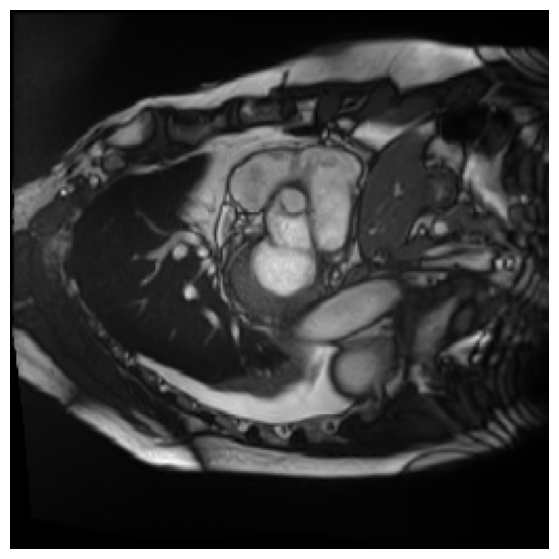

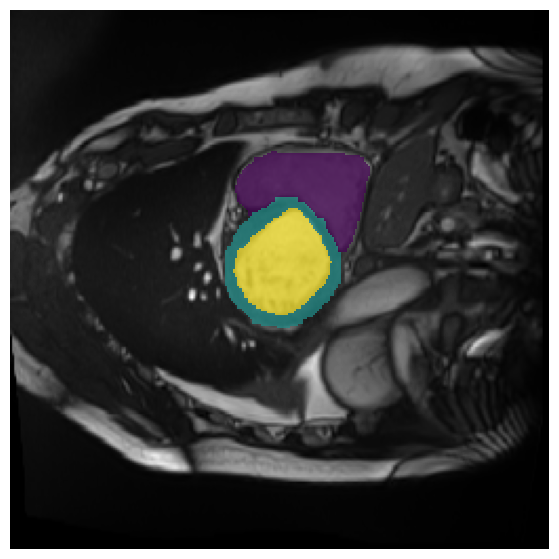

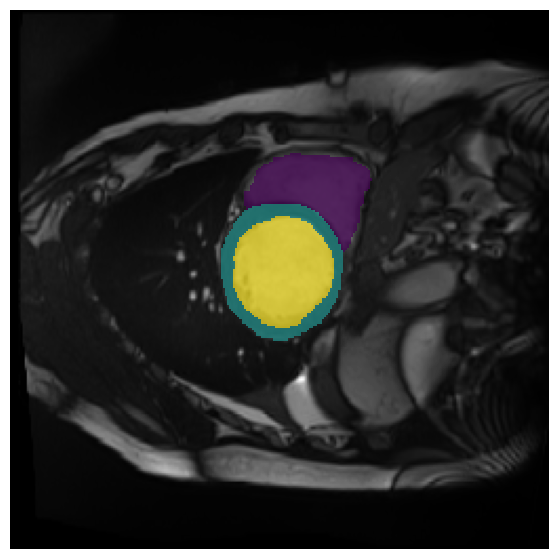

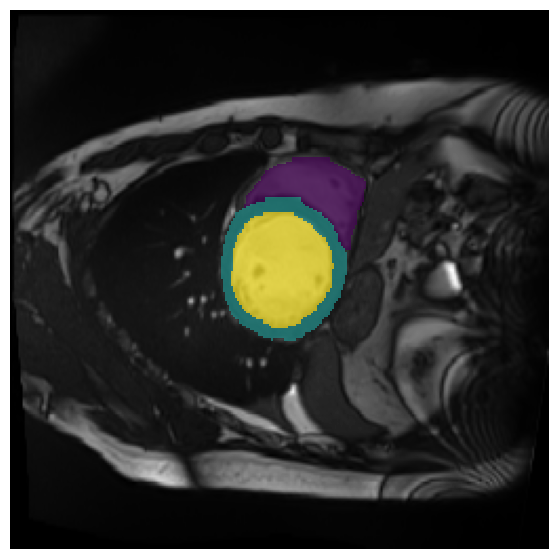

In [14]:
# Visualize samples from the training set
for i in range(4):
    sample = train_dataset[i]
    visualize_heart_sample(sample)

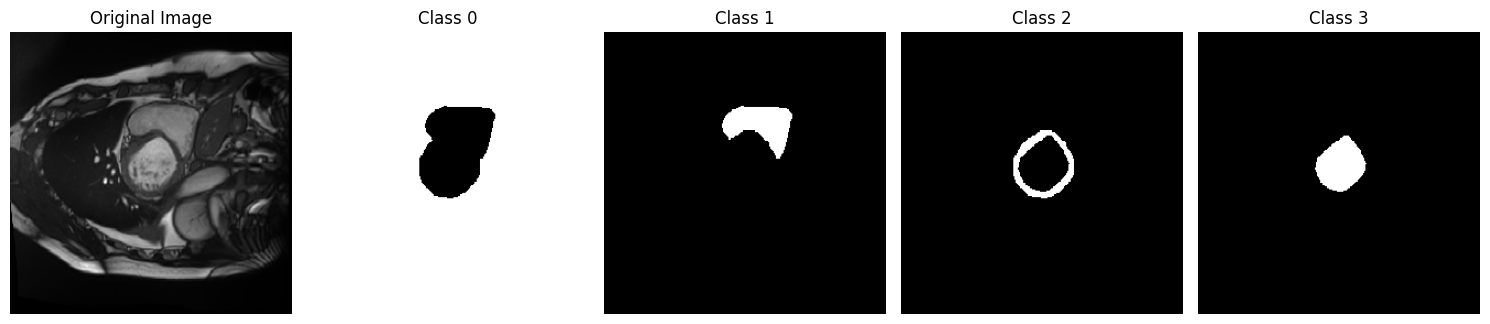

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Select a sample to visualize
sample_idx = 1  # Change this index to visualize different samples

# Load the sample
sample = train_dataset[sample_idx]
img = sample["img"].squeeze()  # Remove channel dimension if necessary
mask = sample["mask"].squeeze()

# Create a figure with subplots: 1 for the image + 4 for the class masks
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

# Plot the original grayscale image
axes[0].imshow(img, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

# Generate binary masks for each class (0, 1, 2, 3)
for i in range(4):  # Iterate over all classes
    class_mask = (mask == i).astype(np.float32)  # Binary mask for class i (black/white)
    axes[i + 1].imshow(class_mask, cmap="gray")  # Black and white colormap
    axes[i + 1].set_title(f"Class {i}")
    axes[i + 1].axis("off")

plt.tight_layout()
plt.show()
